# Notebook to generate graphics combining multiple models

## Load data

In [23]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")
# ---- Figure sizing helpers (SCITEPRESS columns) ----
CM = 1/2.54
COL_W = 7.5 * CM        # single column = 7.5 cm
TWO_COL_W = 15.8 * CM   # two columns = 2*7.5 + 0.8 cm gap

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "STIXGeneral"],
    "mathtext.fontset": "stix",
    "mathtext.rm": "STIXGeneral",
    "mathtext.it": "STIXGeneral:italic",
    "mathtext.bf": "STIXGeneral:bold",

    # --- Larger fonts for small figure widths ---
    "font.size": 14,            # base size
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.titlesize": 14,

    # --- Styling ---
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "legend.frameon": False,

    # --- Vector fonts ---
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    "figure.autolayout": True,
})

In [3]:
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/"
model_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)
dataset_names = sorted(
    [
        d
        for d in os.listdir(log_dir + "/convnext_bs")
        if os.path.isdir(os.path.join(log_dir + "/convnext_bs", d))
    ]
)


# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for model in model_names:
    data[model] = {}

    for i, ds in enumerate(dataset_names):
        data[model][ds] = {}
        color_idx = available_indices[i % len(available_indices)]
        dataset_colors[ds] = colors(color_idx)

        ds_path = os.path.join(log_dir, model, ds)
        pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
        if not pkl_files:
            continue
        # pick most recent file
        pkl_files.sort(
            key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
        )
        file_path = os.path.join(ds_path, pkl_files[0])
        preds, t, metadata, _, _ = load_dump(file_path)
        data[model][ds]["predictions"] = preds
        data[model][ds]["targets"] = t.int()
        data[model][ds]["metadata"] = metadata
        data[model][ds]["color"] = dataset_colors[ds]

# concatenate
valid_dataset_names = [
    (model, ds)
    for model, datasets in data.items()
    for ds, v in datasets.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_dataset_names:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])
Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9

In [4]:
model_colors = {
    "convnext_bs": "red",
    "birdmae": "blue",
    "audioprotopnet": "green",
    "perch_v2": "orange",
}

In [5]:
# compute per-class presence without concatenating all targets into one large tensor
# We'll iterate datasets and maintain a running boolean mask of classes that appear at least once.
num_classes = None
for model, ds in valid_dataset_names:
    t = data[model][ds]["targets"]
    if num_classes is None:
        num_classes = t.shape[1]
        targets_present = torch.zeros(num_classes, dtype=torch.bool, device=t.device)
    # reduce across samples (dim=0) to see which classes are present in this dataset
    ds_present = t.any(dim=0)
    # in-place logical_or to update running presence mask
    targets_present |= ds_present

# If you still need the full concatenated targets tensor later, consider keeping only
# per-model combined targets (already computed below) rather than concatenating all datasets.
# targets_present is a boolean tensor indicating which classes have at least one positive sample
print(f"Number of classes present: {targets_present.sum().item()}")

Number of classes present: 411


### Only select datasets with both predictions and targets

In [6]:
# only select classes with target labels
for model in model_names:
    for key in list(data[model].keys()):
        # keep the dict structure; only replace the predictions/targets tensors
        data[model][key]["predictions"] = data[model][key]["predictions"][
            :, targets_present
        ]
        data[model][key]["targets"] = data[model][key]["targets"][:, targets_present]
    # metadata and color remain unchanged

In [7]:
# add combined predictions/targets for each model
from uncertainbird.utils.plotting import print_metrics


for model in model_names:
    all_preds = torch.cat(
        [data[model][ds]["predictions"] for _, ds in valid_dataset_names], dim=0
    )
    all_tars = torch.cat(
        [data[model][ds]["targets"] for _, ds in valid_dataset_names], dim=0
    )
    data[model]["combined"] = {
        "predictions": all_preds,
        "targets": all_tars,
        "metrics": print_metrics(all_preds, all_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


Accuracy: tensor(0.9985)
cmAP: tensor(0.4136)
Precision: tensor(0.5433)
Recall: tensor(0.1567)
F1 Score: tensor(0.2060)
AUROC: tensor(0.9900)
ECE: tensor(0.0245)
ECE Weighted: tensor(0.0525)
ECE Top-3: tensor(0.0586)
ECE Top-5: tensor(0.0714)
ECE Top-10: tensor(0.0661)
ECE Top-21: tensor(0.0712)
Miscalibration Score (MCS): tensor(0.0443)
ECE Under-confidence: tensor(0.0041)
ECE Over-confidence: tensor(0.0484)
Accuracy: tensor(0.9986)
cmAP: tensor(0.3557)
Precision: tensor(0.5182)
Recall: tensor(0.1857)
F1 Score: tensor(0.2352)
AUROC: tensor(0.9795)
ECE: tensor(0.0347)
ECE Weighted: tensor(0.0762)
ECE Top-3: tensor(0.0843)
ECE Top-5: tensor(0.1063)
ECE Top-10: tensor(0.0948)
ECE Top-21: tensor(0.1042)
Miscalibration Score (MCS): tensor(0.0701)
ECE Under-confidence: tensor(0.0030)
ECE Over-confidence: tensor(0.0732)
Accuracy: tensor(0.9984)
cmAP: tensor(0.3220)
Precision: tensor(0.4748)
Recall: tensor(0.1026)
F1 Score: tensor(0.1409)
AUROC: tensor(0.9812)
ECE: tensor(0.0015)
ECE Weighted

In [8]:
model_mapping = {
    "convnext_bs": "ConvNeXt$_{BS}$",
    "birdmae": "BirdMAE",
    "audioprotopnet": "AudioProtoPNet",
    "perch_v2": "Perch v2",
}

/workspace/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


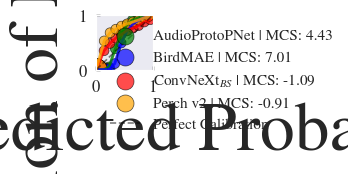

In [25]:
# plot reliability diagram for each model
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {model_mapping[model]: data[model]["combined"] for model in model_names}
ax = plot_combined_reliability_diagram(
    data_for_plot, n_bins=10,
    title=None,
)
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/reliability-combined.pdf
# increase font size to 10
# set width to 250pixels
plt.savefig(
    "/workspace/uncertainbird/results/reliability-combined.pdf", bbox_inches="tight", pad_inches=0.01 
)

## Per class

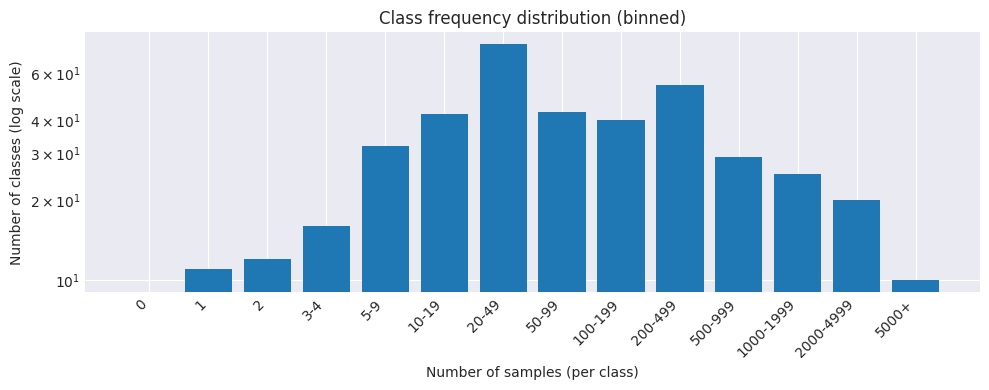

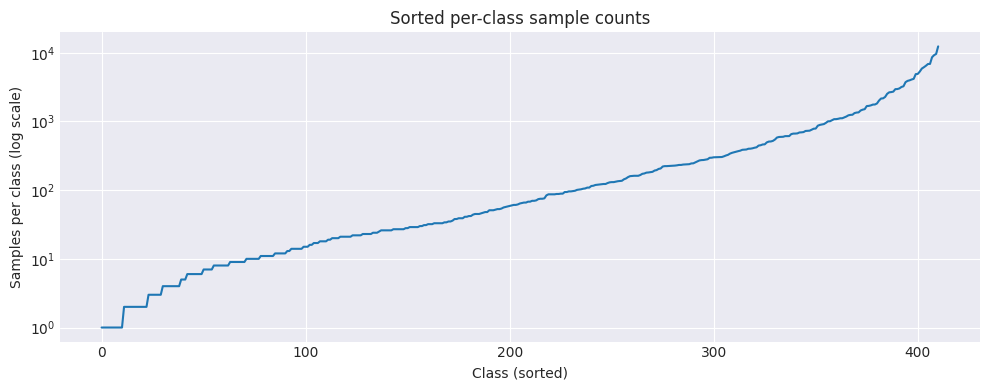

In [ ]:
from uncertainbird.utils.plotting import plot_class_frequency

# plt.rcParams.update({"font.size": 10})
# # set width to 250pixels
# plt.rcParams["figure.figsize"] = [3.459, 3.459]

# Build `targets_targetclasses` efficiently by concatenating only the present-class columns
# from the available `convnext_bs` datasets. This avoids constructing a full (N, C) tensor
# across all classes when many classes are absent.
unique_ds = []
for _, ds in valid_dataset_names:
    if ds in data.get("convnext_bs", {}) and ds not in unique_ds:
        unique_ds.append(ds)

if not unique_ds:
    raise ValueError("No convnext_bs datasets found in valid_dataset_names")

pieces = []
for ds in unique_ds:
    t = data["convnext_bs"][ds]["targets"]
    # select only columns for classes we know to be present
    pieces.append(t)

if pieces:
    targets_targetclasses = torch.cat(pieces, dim=0)
else:
    # empty fallback: zero samples, present-class width
    targets_targetclasses = torch.empty((0, int(targets_present.sum().item())), dtype=torch.int64)

plot_class_frequency(targets_targetclasses)


Number of classes covering 50% of all samples: 19


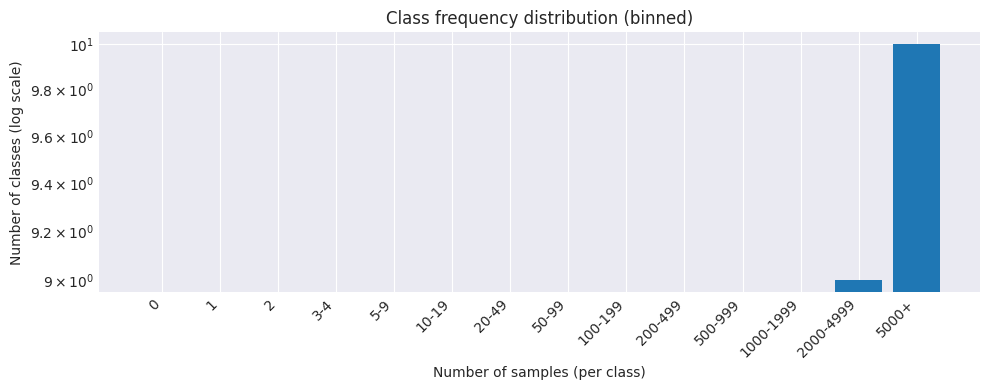

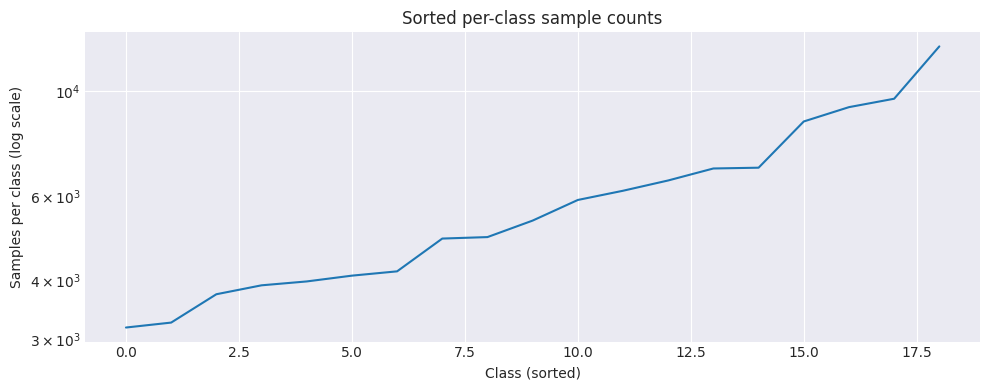

In [11]:
# select classes with most samples such that 50% of all samples are covered
class_counts = targets_targetclasses.sum(dim=0)  # torch tensor
sorted_indices = torch.argsort(class_counts, descending=True)  # no negative strides
cumulative_counts = torch.cumsum(class_counts[sorted_indices], dim=0)
total_counts = cumulative_counts[-1]
threshold = total_counts * 0.5
# first index where cumulative >= threshold
num_classes_50_percent = int(
    (cumulative_counts >= threshold).nonzero(as_tuple=True)[0][0].item() + 1
)
print(f"Number of classes covering 50% of all samples: {num_classes_50_percent}")
selected_indices = sorted_indices[:num_classes_50_percent]
targets_top = targets_targetclasses[:, selected_indices]
plot_class_frequency(targets_top)

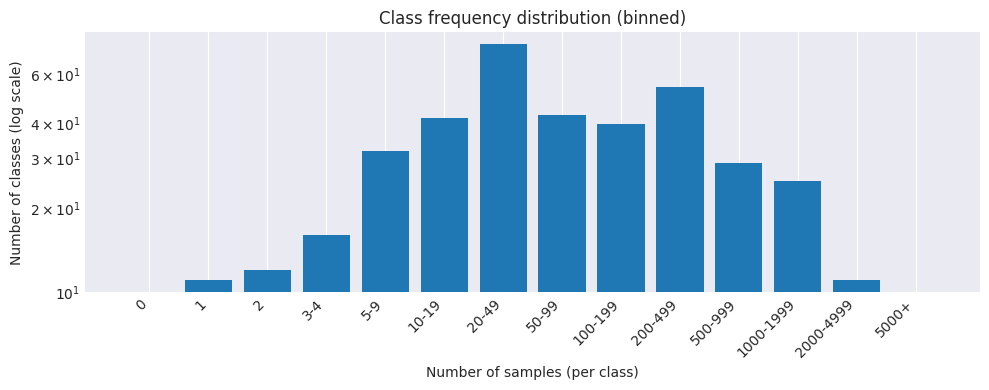

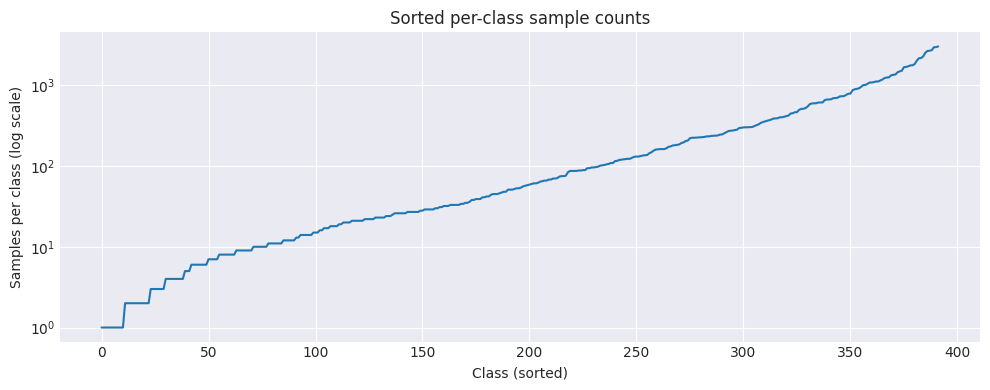

In [12]:
# select the other classes
targets_other = targets_targetclasses[:, sorted_indices[num_classes_50_percent:]]
plot_class_frequency(targets_other)

In [13]:
# preprocess data such that it has the format data[<model_name>]

# build data_for_plot with separate entries for top (50% coverage) and other classes
top_indices = selected_indices
other_indices = sorted_indices[num_classes_50_percent:]

data_for_plot = {}
for model in model_names:
    base_name = model_mapping[model]
    preds = data[model]["combined"]["predictions"]
    tars = data[model]["combined"]["targets"]

    top_preds = preds[:, top_indices]
    top_tars = tars[:, top_indices]
    other_preds = preds[:, other_indices]
    other_tars = tars[:, other_indices]

    data_for_plot[f"{base_name} Top"] = {
        "predictions": top_preds,
        "targets": top_tars,
        "metrics": print_metrics(top_preds, top_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[f"{base_name} Other"] = {
        "predictions": other_preds,
        "targets": other_tars,
        "metrics": print_metrics(other_preds, other_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }

Accuracy: tensor(0.9840)
cmAP: tensor(0.6953)
Precision: tensor(0.8803)
Recall: tensor(0.1642)
F1 Score: tensor(0.2488)
AUROC: tensor(0.9812)
ECE: tensor(0.0739)
ECE Weighted: tensor(0.0697)
ECE Top-3: tensor(0.0586)
ECE Top-5: tensor(0.0714)
ECE Top-10: tensor(0.0661)
ECE Top-21: tensor(0.0739)
Miscalibration Score (MCS): tensor(0.0551)
ECE Under-confidence: tensor(0.0073)
ECE Over-confidence: tensor(0.0624)
Accuracy: tensor(0.9992)
cmAP: tensor(0.3999)
Precision: tensor(0.5270)
Recall: tensor(0.1563)
F1 Score: tensor(0.2039)
AUROC: tensor(0.9904)
ECE: tensor(0.0221)
ECE Weighted: tensor(0.0348)
ECE Top-3: tensor(0.0348)
ECE Top-5: tensor(0.0234)
ECE Top-10: tensor(0.0419)
ECE Top-21: tensor(0.0328)
Miscalibration Score (MCS): tensor(0.0332)
ECE Under-confidence: tensor(0.0008)
ECE Over-confidence: tensor(0.0340)
Accuracy: tensor(0.9851)
cmAP: tensor(0.6481)
Precision: tensor(0.8324)
Recall: tensor(0.2629)
F1 Score: tensor(0.3596)
AUROC: tensor(0.9576)
ECE: tensor(0.1081)
ECE Weighted

In [14]:
# use light color for "Other" classes and dark color for "Top" classes
import matplotlib.colors as mcolors

for key in list(data_for_plot.keys()):
    if "Other" in key:
        base_key = key.replace(" Other", " Top")
        base_color = data_for_plot.get(base_key, {}).get("color", "black")
        # Convert to RGB
        base_rgb = mcolors.to_rgb(base_color)
        # Lighten by moving 50% toward white
        light_rgb = tuple(c + (1.0 - c) * 0.5 for c in base_rgb)
        data_for_plot[key]["color"] = light_rgb
    else:
        # Normalize stored color to an RGB tuple (keeps original tone)
        data_for_plot[key]["color"] = mcolors.to_rgb(data_for_plot[key]["color"])

In [15]:
# replace in model name Top with $\arrowup$ and Other with $\arrowdown$
for key in list(data_for_plot.keys()):
    if "Top" in key:
        new_key = key.replace(" Top", " $\u2191$")
        data_for_plot[new_key] = data_for_plot.pop(key)
    elif "Other" in key:
        new_key = key.replace(" Other", " $\u2193$")
        data_for_plot[new_key] = data_for_plot.pop(key)

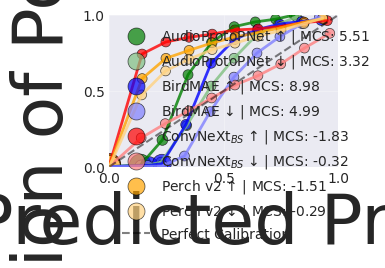

In [ ]:
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)

plt.savefig(
    "/workspace/uncertainbird/results/reliability-top-bottom.pdf", bbox_inches="tight", pad_inches=0.01
)


In [ ]:
# show what classes belong to the top and other groups by plotting the sorted class frequencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Per-class sample counts (multilabel: sum over samples axis)
class_counts = targets.sum(dim=0).cpu().numpy().astype(int)

# Sort counts (optional diagnostic)
sorted_counts = np.sort(class_counts)

# Sorted counts (already log scale)
plt.subplots(figsize=(COL_W, 5.0*CM))

plt.plot(sorted_counts)
plt.ylabel("Samples per class (log scale)")
plt.xlabel("Class (sorted)")
plt.title("Sorted per-class sample counts")
plt.yscale("log")
plt.tight_layout()
plt.show()

NameError: name 'targets' is not defined

### ECE vs sample count

In [ ]:
model_names

['audioprotopnet', 'birdmae', 'convnext_bs', 'perch_v2']

In [ ]:
from uncertainbird.utils.misc import class_wise_statistics

for model in model_names:
    # calculate class-wise statistics
    data[model]["class_stats"] = class_wise_statistics(
        data[model]["combined"]["predictions"].float(),
        data[model]["combined"]["targets"].int(),
        n_bins=10,
    )

In [ ]:
data["convnext_bs"]["class_stats"]

{'mean': tensor([2.8294e-04, 2.8085e-04, 5.3594e-04, 3.3148e-04, 2.0677e-03, 1.4308e-05,
         2.1122e-06, 4.6668e-03, 2.3739e-04, 6.4066e-05, 6.4477e-04, 3.1826e-03,
         1.0561e-04, 2.4518e-05, 1.1443e-04, 1.2752e-05, 1.7481e-04, 1.1609e-04,
         1.0304e-05, 1.2887e-04, 5.2482e-06, 2.9553e-05, 6.2907e-05, 4.5624e-05,
         3.3844e-05, 2.3446e-04, 1.8974e-05, 2.6597e-06, 1.0332e-06, 7.6660e-06,
         1.0063e-03, 1.0354e-05, 5.7471e-05, 7.3312e-05, 1.6472e-06, 1.4429e-05,
         6.9151e-05, 7.1984e-06, 1.0205e-05, 2.5879e-04, 7.6988e-05, 1.8721e-05,
         8.4743e-06, 9.8208e-05, 6.7235e-05, 2.0499e-04, 1.1129e-04, 1.3684e-03,
         1.2107e-04, 5.8807e-07, 2.7843e-04, 3.6045e-04, 3.7672e-05, 1.3670e-04,
         5.8307e-05, 5.4385e-05, 4.3134e-07, 2.0222e-05, 4.7168e-03, 3.0449e-05,
         2.7864e-04, 9.4243e-05, 1.7642e-05, 8.2551e-05, 1.6365e-06, 2.0700e-05,
         7.9078e-05, 3.2245e-05, 6.8301e-05, 2.6589e-04, 1.1472e-03, 4.3256e-04,
         4.7812e-05,

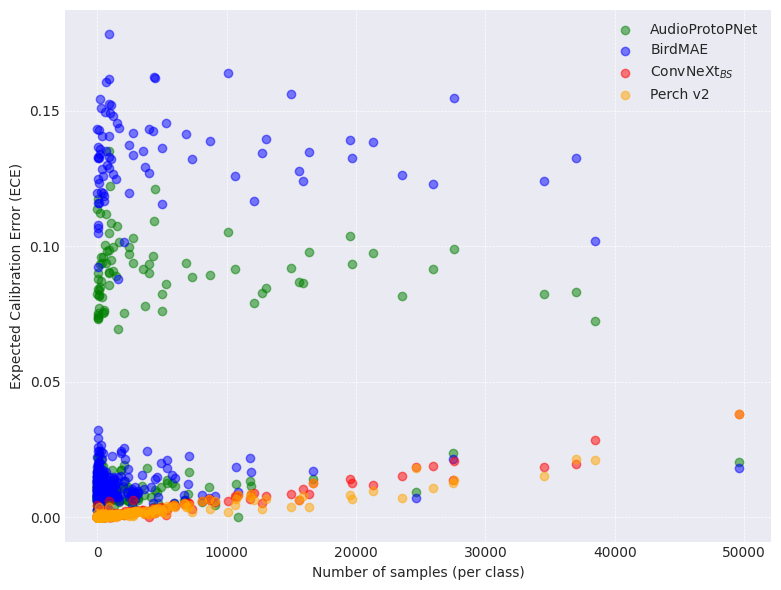

In [ ]:
# plot ece vs class sample count
plt.figure(figsize=(COL_W, 5.0*CM))
# iterate only over the selected models
for model in [
    m
    for m in model_names
    if m in ["convnext_bs", "birdmae", "audioprotopnet", "perch_v2"]
]:
    stats = data.get(model, {}).get("class_stats", {})
    x = stats.get("positive_samples")
    y = stats.get("ece")
    if x is None or y is None:
        # skip if statistics are not available
        continue
    # convert torch tensors to numpy for plotting if necessary
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().numpy()

    plt.scatter(
        x,
        y,
        alpha=0.5,
        color=model_colors.get(model, "black"),
        label=model_mapping.get(model, model),
    )

plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
# plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
# legend
plt.legend()
plt.tight_layout()
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/ece-vs-sample-count.pdf
# increase font size to 24
# plt.rcParams.update({"font.size": 24})
# set width to 250pixels
plt.savefig(
    "/workspace/uncertainbird/results/ece-vs-sample-count.pdf", dpi=500
)
plt.show()

## Per dataset

In [ ]:
# print color for each model
for model in model_names:
    print(f"{model}: {model_colors.get(model, 'black')}")

audioprotopnet: green
birdmae: blue
convnext_bs: red
perch_v2: orange


In [ ]:
data.keys()

dict_keys(['HSN', 'NBP', 'NES', 'PER', 'POW', 'SNE', 'SSW', 'UHH'])

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9944)
cmAP: tensor(0.3174)
Precision: tensor(0.1523)
Recall: tensor(0.0232)
F1 Score: tensor(0.0361)
AUROC: tensor(0.2597)
ECE: tensor(0.0487)
ECE Weighted: tensor(0.1512)
ECE Top-3: tensor(0.1406)
ECE Top-5: tensor(0.1325)
ECE Top-10: tensor(0.1401)
ECE Top-21: tensor(0.1450)
Miscalibration Score (MCS): tensor(0.0616)
ECE Under-confidence: tensor(0.0448)
ECE Over-confidence: tensor(0.1064)
Accuracy: tensor(0.9944)
cmAP: tensor(0.2528)
Precision: tensor(0.1450)
Recall: tensor(0.0300)
F1 Score: tensor(0.0427)
AUROC: tensor(0.2414)
ECE: tensor(0.0629)
ECE Weighted: tensor(0.1811)
ECE Top-3: tensor(0.1665)
ECE Top-5: tensor(0.1498)
ECE Top-10: tensor(0.1787)
ECE Top-21: tensor(0.1883)
Miscalibration Score (MCS): tensor(0.1211)
ECE Under-confidence: tensor(0.0300)
ECE Over-confidence: tensor(0.1511)
Accuracy: tensor(0.9944)
cmAP: tensor(0.2528)
Precision: tensor(0.1450)
Recall: tensor(0.0300)
F1 Score: tensor(0.0427)
AUROC: tensor(0.2414)
ECE: tensor(0.0629)
ECE Weighted

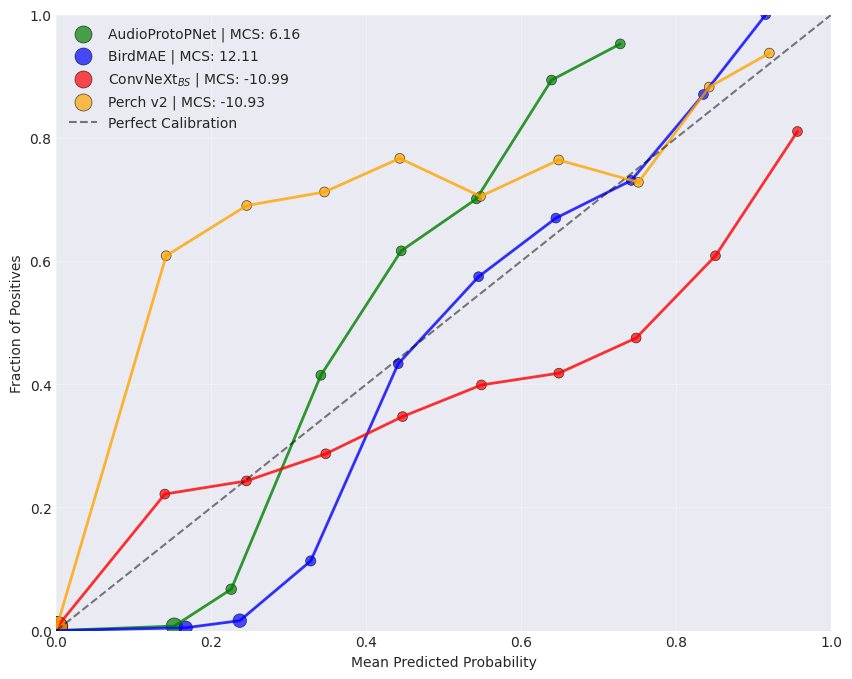

In [ ]:
# plot reliability diagram for each model for the PER dataset

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {}
for model in model_names:
    entry = data[model].get("PER")
    if entry is None:
        continue
    # reuse predictions/targets but create a shallow copy so we don't mutate original
    new_entry = {
        "predictions": entry["predictions"],
        "targets": entry["targets"],
        "metadata": entry.get("metadata"),
        # use existing metrics if present, otherwise compute
        "metrics": entry.get(
            "metrics", print_metrics(entry["predictions"], entry["targets"])
        ),
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[model_mapping[model]] = new_entry
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/reliability-combined.pdf
# increase font size to 10

plt.savefig("/workspace/uncertainbird/results/reliability-PER.pdf", bbox_inches="tight", pad_inches=0.01)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9940)
cmAP: tensor(0.5066)
Precision: tensor(0.0745)
Recall: tensor(0.0254)
F1 Score: tensor(0.0305)
AUROC: tensor(0.1039)
ECE: tensor(0.0216)
ECE Weighted: tensor(0.2415)
ECE Top-3: tensor(0.2785)
ECE Top-5: tensor(0.2322)
ECE Top-10: tensor(0.1963)
ECE Top-21: tensor(0.1836)
Miscalibration Score (MCS): tensor(-0.0692)
ECE Under-confidence: tensor(0.1554)
ECE Over-confidence: tensor(0.0862)
Accuracy: tensor(0.9944)
cmAP: tensor(0.3951)
Precision: tensor(0.0736)
Recall: tensor(0.0225)
F1 Score: tensor(0.0286)
AUROC: tensor(0.0970)
ECE: tensor(0.0236)
ECE Weighted: tensor(0.2208)
ECE Top-3: tensor(0.2273)
ECE Top-5: tensor(0.1972)
ECE Top-10: tensor(0.1782)
ECE Top-21: tensor(0.1902)
Miscalibration Score (MCS): tensor(-0.0271)
ECE Under-confidence: tensor(0.1240)
ECE Over-confidence: tensor(0.0968)
Accuracy: tensor(0.9944)
cmAP: tensor(0.3951)
Precision: tensor(0.0736)
Recall: tensor(0.0225)
F1 Score: tensor(0.0286)
AUROC: tensor(0.0970)
ECE: tensor(0.0236)
ECE Weight

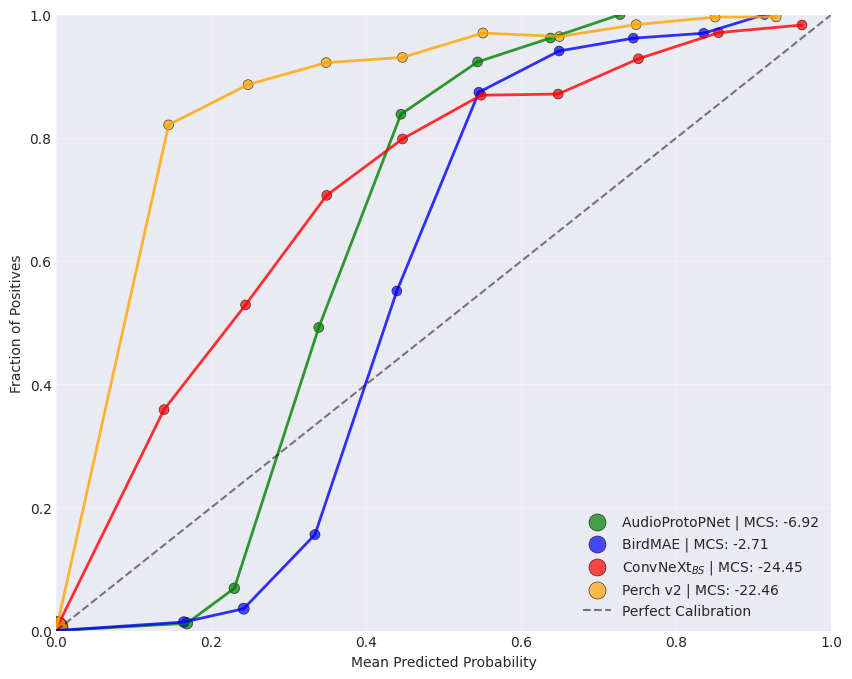

In [ ]:
# plot reliability diagram for each model for the POW dataset

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {}
for model in model_names:
    entry = data[model].get("POW")
    if entry is None:
        continue
    # reuse predictions/targets but create a shallow copy so we don't mutate original
    new_entry = {
        "predictions": entry["predictions"],
        "targets": entry["targets"],
        "metadata": entry.get("metadata"),
        # use existing metrics if present, otherwise compute
        "metrics": entry.get(
            "metrics", print_metrics(entry["predictions"], entry["targets"])
        ),
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[model_mapping[model]] = new_entry
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)

plt.savefig("/workspace/uncertainbird/results/reliability-POW.pdf", bbox_inches="tight", pad_inches=0.01)